In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
!sudo apt install tesseract-ocr
!pip install pytesseract
from glob import glob
from skimage import io
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = glob('/content/drive/MyDrive/Dataset/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [6]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/Dataset/images/N15.xml,582,853,622,691
1,/content/drive/MyDrive/Dataset/images/N175.xml,183,250,205,229
2,/content/drive/MyDrive/Dataset/images/N167.xml,345,848,242,416
3,/content/drive/MyDrive/Dataset/images/N121.xml,311,506,324,370
4,/content/drive/MyDrive/Dataset/images/N138.xml,36,465,64,168


In [7]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/drive/MyDrive/Dataset/images',filename_image)
    return filepath_image
getFilename(filename)

'/content/drive/MyDrive/Dataset/images/N15.jpeg'

In [8]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['/content/drive/MyDrive/Dataset/images/N15.jpeg',
 '/content/drive/MyDrive/Dataset/images/N175.jpeg',
 '/content/drive/MyDrive/Dataset/images/N167.jpeg',
 '/content/drive/MyDrive/Dataset/images/N121.jpeg',
 '/content/drive/MyDrive/Dataset/images/N138.jpeg',
 '/content/drive/MyDrive/Dataset/images/N133.jpeg',
 '/content/drive/MyDrive/Dataset/images/N129.jpeg',
 '/content/drive/MyDrive/Dataset/images/N142.jpeg',
 '/content/drive/MyDrive/Dataset/images/N17.jpeg',
 '/content/drive/MyDrive/Dataset/images/N105.jpeg']

In [10]:

labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [11]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

Now split the data into training and testing set using __sklearn__.

In [12]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [13]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 1s 0us/step


In [14]:

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [15]:

history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=30,
                    validation_data=(x_test,y_test))

Epoch 1/30
18/18 [==============================] - 103s 495ms/step - loss: 0.0397 - val_loss: 0.0359
Epoch 2/30
18/18 [==============================] - 4s 233ms/step - loss: 0.0170 - val_loss: 0.0244
Epoch 3/30
18/18 [==============================] - 4s 230ms/step - loss: 0.0085 - val_loss: 0.0162
Epoch 4/30
18/18 [==============================] - 4s 227ms/step - loss: 0.0044 - val_loss: 0.0155
Epoch 5/30
18/18 [==============================] - 4s 229ms/step - loss: 0.0037 - val_loss: 0.0120
Epoch 6/30
18/18 [==============================] - 4s 235ms/step - loss: 0.0027 - val_loss: 0.0108
Epoch 7/30
18/18 [==============================] - 4s 228ms/step - loss: 0.0026 - val_loss: 0.0108
Epoch 8/30
18/18 [==============================] - 4s 229ms/step - loss: 0.0025 - val_loss: 0.0111
Epoch 9/30
18/18 [==============================] - 4s 238ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 10/30
18/18 [==============================] - 4s 233ms/step - loss: 0.0015 - val_loss: 0.01

In [17]:
model.save('Model.h5')

In [ ]:
# Load model
model = tf.keras.models.load_model('.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


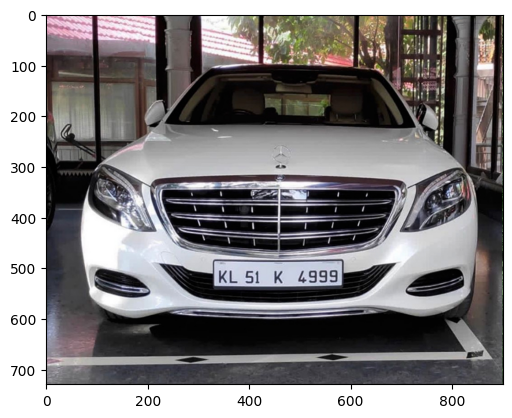

In [67]:
path = '/content/drive/MyDrive/Dataset/TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output/
plt.imshow(image)



In [37]:
image_arr_224.shape

(224, 224, 3)

In [38]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [39]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 0s 40ms/step


array([[0.403743 , 0.6257287, 0.6300898, 0.7173413]], dtype=float32)

In [40]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[363.77244195, 563.78158247, 459.33547837, 522.94181049]])

In [41]:
coords = coords.astype(np.int32)
coords

array([[363, 563, 459, 522]], dtype=int32)

In [42]:

xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(363, 459) (563, 522)


In [43]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
plt.imshow(image)

In [45]:

path = '/content/drive/MyDrive/Dataset/TEST/TEST.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)
plt.imshow

1/1 [==============================] - 0s 37ms/step
(363, 459) (563, 522)


In [46]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
plt.imshow(roi)

In [65]:
# extract text from image
import pytesseract as pt
text = pt.image_to_string(roi)
print(text)